In [116]:
import math
import random
from enum import Enum

import networkx as nx

from mesa import Agent, Model
from mesa.time import StagedActivation
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import NetworkGrid

from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from pyvis.network import Network

import math

from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.UserParam import UserSettableParameter
from mesa.visualization.modules import ChartModule
from mesa.visualization.modules import NetworkModule
from mesa.visualization.modules import TextElement

import pandas as pd 
import numpy as np
import scipy.sparse as sps
import scipy as sp

import matplotlib.pyplot as plt

import multinetx as mx

In [117]:
def make_dict(role_list, dict_type):
    'Be aware, this function includes a lot of hardcoding, which makes it less versatile. '
    'However it does make it convenient for choosing exact colors for specific roles. '
    'It is important to have the same order of roles as much as possible. '
    
    # Set color dict
    if dict_type == 'color':
        return_dict = {role_list[0]: 'red'} | dict.fromkeys(role_list[1], 'orange') | \
        dict.fromkeys(role_list[2], 'yellow') | dict.fromkeys(role_list[3], 'blue') | \
        dict.fromkeys(role_list[4], 'green') | dict.fromkeys(role_list[5], 'pink')
        
    # Set business name dict
    elif dict_type == 'business_name':
        return_dict = {role_list[0]: 'kingpin_main'} | \
        {c:'kingpin_'+str(i) for i, c in enumerate(role_list[1])} | \
        {c:'orphan_'+str(i) for i, c in enumerate(role_list[2])} | \
        {c:'broker_'+str(i) for i, c in enumerate(role_list[3])} | \
        {c:'dealer_'+str(i) for i, c in enumerate(role_list[4])} | \
        {c:'coordinator_'+str(i) for i, c in enumerate(role_list[5])}
        
    # Set family name dict
    elif dict_type == 'family_name':
        return_dict = {role_list[0]: 'father_main'} | \
        {c:'cousin_'+str(i) for i, c in enumerate(role_list[1])} | \
        {c:'brother_'+str(i) for i, c in enumerate(role_list[2])} | \
        {c:'friend_'+str(i) for i, c in enumerate(role_list[3])} | \
        {c:'driver_'+str(i) for i, c in enumerate(role_list[4])} | \
        {c:'contact_'+str(i) for i, c in enumerate(role_list[5])}
        
    elif dict_type == 'weight':
        return_dict = {role_list[0]: 100} | dict.fromkeys(role_list[1], 75) | \
        dict.fromkeys(role_list[2], 90) | dict.fromkeys(role_list[3], 50) | \
        dict.fromkeys(role_list[4], 40) | dict.fromkeys(role_list[5], 30)
        
    return return_dict

In [118]:
def add_edge_list(G, role_list1, role_list2, prob, role_color, role_weight, interconnected=False):
    'Function to add edges according to the input parameters'
    
    # Regular edges
    for c in role_list1:
        edge_list = []
        for x in role_list2:
            if ((c is not x) and (random.uniform(0, 1) < prob)):
                if (c, x) in G.edges():
                    G.remove_edge(c, x)
                elif (x, c) in G.edges():
                    G.remove_edge(x, c)
                edge_list += [(c, x)]
        G.add_edges_from(edge_list, color=role_color, weight=role_weight)   
    
    # Interconnected edges between same group
    if interconnected:
        for c in role_list1:
            edge_list = []
            for x in role_list1:
                if c is not x:
                    if (c, x) in G.edges():
                        G.remove_edge(c, x)
                    elif (x, c) in G.edges():
                        G.remove_edge(x, c)
                    edge_list += [(c, x)]
            G.add_edges_from(edge_list, color=role_color, weight=role_weight)   


In [119]:
# Function to create list of connected networks ('N>30')
def create_networks(networks, N=30):
    'Function to create the networks involved'
    # Return list with created networks
    network_list = []
    
    # Create IDs for agents
    shuffled = random.sample(range(0, N), N)
    shuffledf = random.sample(range(0, N), N)

    # Set roles business
    kingpin_main = shuffled[0]
    kingpin_list = shuffled[1:4]
    orphan_list = shuffled[4:8]
    broker_list = shuffled[8:16]
    dealer_list = shuffled[16:23]
    coordinator_list = shuffled[23:N]
    
    # set roles family/social
    father_main = shuffledf[0]
    cousin_list = shuffledf[1:4]
    brother_list = shuffledf[4:8]
    friend_list = shuffledf[8:16]
    driver_list = shuffledf[16:23]
    contact_list = shuffledf[23:N]
    
    # Create business/social role lists
    business_role_list = [kingpin_main, kingpin_list, orphan_list, broker_list, dealer_list, coordinator_list]
    family_role_list = [father_main, cousin_list, brother_list, friend_list, driver_list, contact_list]
    
    # Make dictionaries for attributes
    business_color_dict = make_dict(business_role_list, 'color')
    family_color_dict = make_dict(family_role_list, 'color')
    business_name_dict = make_dict(business_role_list, 'business_name')
    family_name_dict = make_dict(family_role_list, 'family_name')
    business_weight_dict = make_dict(business_role_list, 'weight')
    family_weight_dict = make_dict(family_role_list, 'weight')
        
    # Create each network
    for name in networks:
        
        # Start with empty network
        G = nx.empty_graph(N)
        
        # Set names, colours and weights
        nx.set_node_attributes(G, business_name_dict, "business_name")
        nx.set_node_attributes(G, family_name_dict, "family_name")
        nx.set_node_attributes(G, business_color_dict, "business_color")
        nx.set_node_attributes(G, family_color_dict, "family_color")
        nx.set_node_attributes(G, business_weight_dict, "business_weight")
        nx.set_node_attributes(G, family_weight_dict, "family_weight")
        
        # For business network
        if name == 'business':
            
            # Add edge lists including weight and colours
            add_edge_list(G, coordinator_list, G.nodes(), 0.1, 'pink', 30) 
            add_edge_list(G, dealer_list, G.nodes(), (1/6), 'green', 50) 
            add_edge_list(G, broker_list, G.nodes(), 0.25, 'blue', 70) 
            add_edge_list(G, orphan_list, G.nodes(), (1/3), 'yellow', 80, True) 
            add_edge_list(G, kingpin_list, G.nodes(), 0.25, 'orange', 100)
            add_edge_list(G, [kingpin_main], G.nodes(), 1, 'red', 100)

            # Append network for returning
            network_list.append(G)

            # Get node and edge colours for drawing
            business_values = [business_color_dict.get(node, 'k') for node in G.nodes()]
            edge_colors = nx.get_edge_attributes(G,'color').values()
            
            # Draw network
            nx.draw(G, with_labels=True, edge_color=edge_colors, node_color=business_values)
            plt.show()
            
        # For social network
        if name == 'social':
            
            # Add edge lists including weight and colours
            add_edge_list(G, driver_list, contact_list, 1, 'green', 50, True) 
            add_edge_list(G, friend_list, driver_list, 1, 'blue', 70, True) 
            add_edge_list(G, brother_list, friend_list, 1, 'yellow', 80, True) 
            add_edge_list(G, cousin_list, friend_list, 1, 'orange', 70, True) 
            add_edge_list(G, [father_main], G.nodes(), 1, 'red', 100, True) 

            # Append network for returning
            network_list.append(G)           
                
            # Get node and edge colours for drawing
            family_colors = nx.get_edge_attributes(G,'color').values()
            family_values = [family_color_dict.get(node, 'k') for node in G.nodes()]

            # Draw network
            nx.draw(G, with_labels=True, edge_color=family_colors, node_color=family_values)
            plt.show()

    return network_list

In [120]:
class Agents(Agent):
    def __init__ (self, unique_ID, model, gender):
        'Initialisation function of model'
        super(). __init__(unique_ID, model)
    
        self.ID = unique_ID
        self.violence = random.uniform(0,1)
        if random.uniform(0,1) < gender:
            self.gen = "m"
        else:
            self.gen = "f"
    
    def step(self):
        print('test')
        
    def stage1(self):
        print('stage1')
        
    def stage2(self):
        print('stage2')
        
    def stage3(self):
        print('stage3')
    
    def stage4(self):
        print('stage4')

In [121]:
class ReplacementModel(Model):
    
    def __init__ (self, phase, gender_choosing):
        'Initialisation function of model'
        self.schedule = StagedActivation(self, stage_list = ['stage1', 'stage2', 'stage3', 'stage4'])
        
        # Create and store networks
        self.nets = create_networks(['business', 'social'])
        self.business = self.nets[0]
        self.social = self.nets[1]
        
        # Store information dictionaries
        self.business_name_dict = nx.get_node_attributes(self.business,'business_name').values()
        self.family_name_dict = nx.get_node_attributes(self.social,'family_name').values()
        self.business_color_dict = nx.get_node_attributes(self.business,'business_color').values()
        self.family_color_dict = nx.get_node_attributes(self.social,'family_color').values()
        self.business_edge_colors = nx.get_edge_attributes(self.business,'color').values()
        self.family_edge_colors = nx.get_edge_attributes(self.social,'color').values()
        
        # Add all nodes to schedule
        for node in self.business:
            a = Agents(node, self, gender_choosing)
            self.schedule.add(a)
    
    def remove_king(self):
        'Function to remove king'
        names=nx.get_node_attributes(self.business,'business_name')
        for agent in model.schedule.agents:
            if names[agent.ID] == 'kingpin_main':
                self.business.remove_node(agent.ID)
                self.social.remove_node(agent.ID)
                self.schedule.remove(agent)
                self.update_dicts()

    def check_violence(self):
        'Function to check violence'
        violence = 0
        for agent in self.schedule.agents:
            violence += agent.violence
        violence_average = violence / len(self.schedule.agents)
        
    def update_dicts(self):
        'Function to update information dictionaries'
        self.business_name_dict = nx.get_node_attributes(self.business,'business_name').values()
        self.family_name_dict = nx.get_node_attributes(self.social,'family_name').values()
        self.business_color_dict = nx.get_node_attributes(self.business,'business_color').values()
        self.family_color_dict = nx.get_node_attributes(self.social,'family_color').values()
        self.business_edge_colors = nx.get_edge_attributes(self.business,'color').values()
        self.family_edge_colors = nx.get_edge_attributes(self.social,'color').values()

    def draw_networks(self):
        'Function to draw the networks involved'
        self.update_dicts() 
        
        # Business network
        nx.draw(self.business, with_labels=True, edge_color=self.business_edge_colors, \
                node_color=self.business_color_dict)
        plt.show()
        
        # Family network
        nx.draw(self.social, with_labels=True, edge_color=self.family_edge_colors, \
                node_color=self.family_color_dict)
        plt.show()
        
        
    def step(self):
        'Step Function of model'
        self.draw_networks()
        self.check_violence()
        self.remove_king()
        self.schedule.step()
        self.draw_networks()

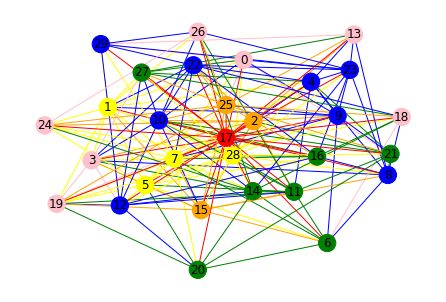

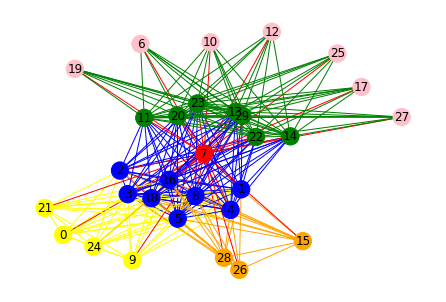

In [122]:
nets = create_networks(['business', 'social'])

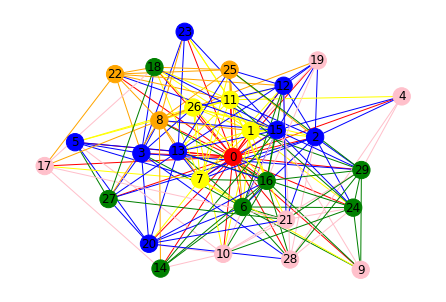

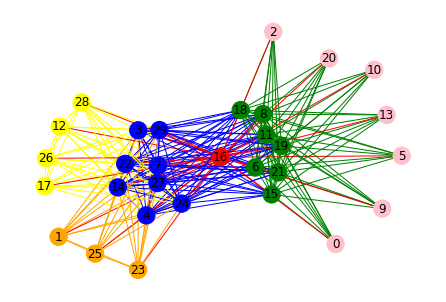

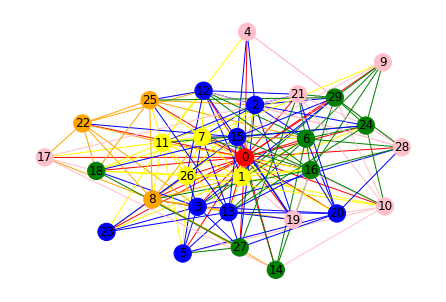

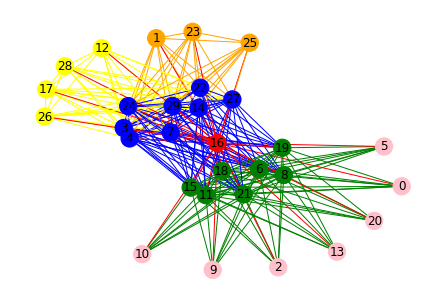

stage1
stage1
stage1
stage1
stage1
stage1
stage1
stage1
stage1
stage1
stage1
stage1
stage1
stage1
stage1
stage1
stage1
stage1
stage1
stage1
stage1
stage1
stage1
stage1
stage1
stage1
stage1
stage1
stage1
stage2
stage2
stage2
stage2
stage2
stage2
stage2
stage2
stage2
stage2
stage2
stage2
stage2
stage2
stage2
stage2
stage2
stage2
stage2
stage2
stage2
stage2
stage2
stage2
stage2
stage2
stage2
stage2
stage2
stage3
stage3
stage3
stage3
stage3
stage3
stage3
stage3
stage3
stage3
stage3
stage3
stage3
stage3
stage3
stage3
stage3
stage3
stage3
stage3
stage3
stage3
stage3
stage3
stage3
stage3
stage3
stage3
stage3
stage4
stage4
stage4
stage4
stage4
stage4
stage4
stage4
stage4
stage4
stage4
stage4
stage4
stage4
stage4
stage4
stage4
stage4
stage4
stage4
stage4
stage4
stage4
stage4
stage4
stage4
stage4
stage4
stage4


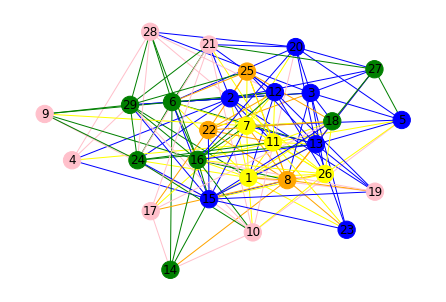

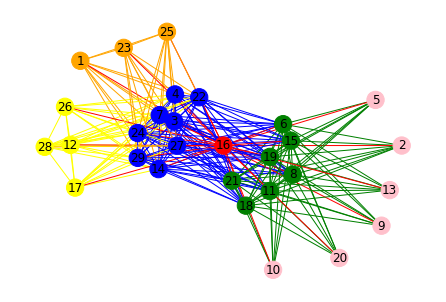

In [123]:
model = ReplacementModel('phase', 0.9)
for i in range(1):
    model.step()